# Setup

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import (
    MetricFrame, false_positive_rate, false_negative_rate, false_negative_rate_difference,
    false_positive_rate_difference, demographic_parity_ratio, equalized_odds_ratio, selection_rate_difference)
from IPython.display import display

In [2]:
# read in data
df_train = pd.read_csv("data/train.csv")
df_songs = pd.read_csv("data/songs.csv")
df_artists = pd.read_csv("data/artists.csv")

df_artists.rename(columns={"gender": "artist_gender"}, inplace=True)
df_artists.rename(columns={"country": "artist_country"}, inplace=True)

In [3]:
# merge data together
seeds = [85, 25, 121, 61, 73, 37, 97, 49, 109, 13]
popularity_tresholds = [100, 1000]
popularity_func = lambda x: 'high' if x >= popularity_tresholds[1] else 'medium' if x >= popularity_tresholds[0] else 'low'

df_info = df_train.merge(df_songs, on="song_id", how="left")
df_info = df_info.merge(df_artists, on="artist_name", how="left")
artist_listeners = df_info.groupby('artist_name')['msno'].nunique()
df_info['artist_listeners'] = df_info['artist_name'].map(artist_listeners)
df_info['artist_popularity'] = df_info['artist_listeners'].apply(popularity_func)

merged_dfs = []

for seed in seeds:
    predictions = pd.read_csv(f"data/predictions/final/final_seed{seed}.csv")
    df_merged = predictions.merge(df_info, on=["song_id", "msno"], how="left")
    df_merged['prediction'] = df_merged['probability'] >= 0.5
    merged_dfs.append(df_merged)

# Overall Performance

In [11]:
performance_metrics = {
    "Accuracy": accuracy_score,
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=np.nan),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=np.nan),
    "FNR": false_negative_rate,
    "FPR": false_positive_rate,
}

def get_performance_metrics(y_true, y_pred):
    return {name: func(y_true, y_pred) for name, func in performance_metrics.items()}

def get_fairness_metrics(y_true, y_pred, sensitive_features):
    fnr_difference = false_negative_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fpr_difference = false_positive_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    dpr = demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    eor = equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    sr_difference = selection_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)

    return {
        'FNR Difference': fnr_difference,
        'FPR Difference': fpr_difference,
        'Demographic Parity Ratio': dpr,
        'Equalized Odds Ratio': eor,
        'Selection Rate Difference': sr_difference
    }

In [6]:
# Get performance metrics
rows = []

for df in merged_dfs:
    y_pred = df["prediction"]
    y_true = df["target"]

    row = {name: func(y_true, y_pred) for name, func in performance_metrics.items()}
    rows.append(row)

df_performance_metrics = pd.DataFrame(rows)
df_performance_metrics

,Accuracy,Precision,Recall,FNR,FPR
0,0.765222,0.775116,0.754591,0.245409,0.223906
1,0.766371,0.776813,0.754797,0.245203,0.221792
2,0.765735,0.776692,0.753244,0.246756,0.221490
3,0.765873,0.776507,0.753952,0.246048,0.221934
4,0.765625,0.776225,0.753759,0.246241,0.222238
5,0.766197,0.777379,0.753323,0.246677,0.220637
6,0.765919,0.776709,0.753725,0.246275,0.221610
7,0.766405,0.776757,0.754989,0.245011,0.221920
8,0.766265,0.777363,0.753540,0.246460,0.220720
9,0.767076,0.777753,0.755104,0.244896,0.220680


In [7]:
# Average performance metrics
df_performance_metrics.mean()

Accuracy     0.766069
Precision    0.776731
Recall       0.754102
FNR          0.245898
FPR          0.221693
dtype: float64

# Artist Gender Metrics

In [8]:
gender_filtered_dfs = []
analysis_genders = ['Male', 'Female'] # filter out missing values, and genders with low counts (non-binary, not applicable, etc.)

for df in merged_dfs:
    filtered_df = df[df['artist_gender'].isin(analysis_genders)].copy()
    gender_filtered_dfs.append(filtered_df)

In [ ]:
# Proportion of total listens by gender
df_info_gender_filtered = df_info[df_info['artist_gender'].isin(analysis_genders)]
df_info_gender_filtered['artist_gender'].value_counts(normalize=True)

artist_gender
Male      0.543741
Female    0.456259
Name: proportion, dtype: float64

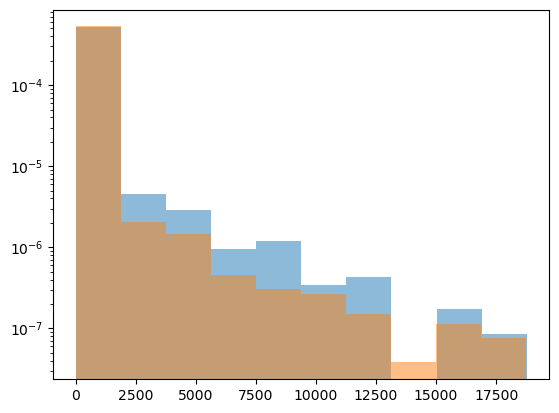

In [36]:
# Number of unique listeners by gender
male_listeners = df_artists[df_artists['artist_gender'] == 'Male']['artist_name'].map(artist_listeners)
female_listeners = df_artists[df_artists['artist_gender'] == 'Female']['artist_name'].map(artist_listeners)

plt.hist(female_listeners, density=True, alpha=0.5)
plt.hist(male_listeners, density=True, alpha=0.5)

plt.yscale('log')

In [ ]:
# average number of listeners by gender
print(male_listeners.mean())
print(female_listeners.mean())

85.35688945650631
157.87287045965928


In [41]:
# proportion of artists by gender
df_artists[df_artists['artist_gender'].isin(analysis_genders)]['artist_gender'].value_counts(normalize=True)

artist_gender
Male      0.693739
Female    0.306261
Name: proportion, dtype: float64

In [8]:
# Proportion of positive predictions by gender
counts_list = []

for df in gender_filtered_dfs:
    counts = df[df['prediction'] == 1].groupby('artist_gender').size()
    counts_list.append(counts)

average = pd.concat(counts_list, axis=1).mean(axis=1)

percent = (average / average.sum()) * 100
print(percent)

artist_gender
Female    44.65228
Male      55.34772
dtype: float64


In [14]:
# Proportion of negative predictions by gender
counts_list = []

for df in gender_filtered_dfs:
    counts = df[df['prediction'] == 0].groupby('artist_gender').size()
    counts_list.append(counts)

average = pd.concat(counts_list, axis=1).mean(axis=1)

percent = (average / average.sum()) * 100
print(percent)

artist_gender
Female    46.55983
Male      53.44017
dtype: float64


In [9]:
# Within gender, proportion of positive predictions
value_counts_list = []

for df in gender_filtered_dfs:
    value_counts = df.groupby('artist_gender')['prediction'].value_counts(normalize=True)
    value_counts_list.append(value_counts)

average_value_counts = pd.concat(value_counts_list, axis=1).mean(axis=1)
average_value_counts

artist_gender  prediction
Female         False         0.513169
               True          0.486831
Male           True          0.506054
               False         0.493946
dtype: float64

In [10]:
# Performance Metrics
gender_metric_frames = []

for df in gender_filtered_dfs:
    metric_frame = MetricFrame(
        metrics=performance_metrics,
        y_true=df['target'],
        y_pred=df['prediction'],
        sensitive_features=df['artist_gender']
    )
    gender_metric_frames.append(metric_frame)

by_genders = pd.concat([gmf.by_group for gmf in gender_metric_frames])
by_genders

,Accuracy,Precision,Recall,FNR,FPR
artist_gender,,,,,
Female,0.761891,0.770817,0.748501,0.251499,0.224595
Male,0.767974,0.781750,0.766066,0.233934,0.229974
Female,0.762565,0.772076,0.748528,0.251472,0.223253
Male,0.768475,0.782111,0.766002,0.233998,0.228873
Female,0.761376,0.770650,0.745730,0.254270,0.222909
Male,0.768034,0.782361,0.764480,0.235520,0.228154
Female,0.761709,0.770921,0.747561,0.252439,0.224024
Male,0.768402,0.782668,0.765070,0.234930,0.228022
Female,0.761963,0.770539,0.748633,0.251367,0.224606


In [11]:
# Average metrics by gender
by_gender_averages = by_genders.groupby('artist_gender').mean()
by_gender_averages

,Accuracy,Precision,Recall,FNR,FPR
artist_gender,,,,,
Female,0.762354,0.771622,0.748136,0.251864,0.223308
Male,0.768591,0.782634,0.765376,0.234624,0.227962


In [12]:
# Fairness metrics
gender_fairness_metrics = []

for df in gender_filtered_dfs:
    gender_fairness_metrics.append(get_fairness_metrics(df['target'], df['prediction'], df['artist_gender']))

In [13]:
df_gender_fairness_metrics = pd.DataFrame(gender_fairness_metrics)
df_gender_fairness_metrics

,FNR Difference,FPR Difference,Demographic Parity Ratio,Equalized Odds Ratio,Selection Rate Difference
0,0.017565,0.005379,0.960614,0.976609,0.019998
1,0.017474,0.005619,0.961341,0.975448,0.019593
2,0.018751,0.005246,0.958778,0.975473,0.020848
3,0.017508,0.003998,0.962172,0.977116,0.019142
4,0.016158,0.003126,0.964314,0.978873,0.018044
5,0.016273,0.004278,0.963813,0.978711,0.018276
6,0.016942,0.006481,0.960430,0.971592,0.020010
7,0.016199,0.004188,0.962764,0.978853,0.018854
8,0.018277,0.004368,0.962384,0.976129,0.019023
9,0.017257,0.003856,0.963539,0.977492,0.018441


In [14]:
df_gender_fairness_metrics.mean()

FNR Difference               0.017241
FPR Difference               0.004654
Demographic Parity Ratio     0.962015
Equalized Odds Ratio         0.976629
Selection Rate Difference    0.019223
dtype: float64

In [ ]:
# proportion of positive predictions by artist

# Artist Popularity Metrics

In [1]:
# Proportion of positive predictions by popularity
counts_list = []

for df in merged_dfs:
    counts = df[df['prediction'] == 1].groupby('artist_popularity').size()
    counts_list.append(counts)

average = pd.concat(counts_list, axis=1).mean(axis=1)

percent = (average / average.sum()) * 100
print(percent)

NameError: name 'merged_dfs' is not defined

In [16]:
# Within popularity, proportion of positive predictions
value_counts_list = []

for df in merged_dfs:
    value_counts = df.groupby('artist_popularity')['prediction'].value_counts(normalize=True)
    value_counts_list.append(value_counts)

average_value_counts = pd.concat(value_counts_list, axis=1).mean(axis=1)
average_value_counts

artist_popularity  prediction
high               True          0.535521
                   False         0.464479
low                False         0.704844
                   True          0.295156
medium             False         0.625102
                   True          0.374898
dtype: float64

In [17]:
# Performance Metrics
popularity_metric_frames = []

for df in merged_dfs:
    metric_frame = MetricFrame(
        metrics=performance_metrics,
        y_true=df['target'],
        y_pred=df['prediction'],
        sensitive_features=df['artist_popularity']
    )
    popularity_metric_frames.append(metric_frame)

by_popularity = pd.concat([pmf.by_group for pmf in popularity_metric_frames])
by_popularity

,Accuracy,Precision,Recall,FNR,FPR
artist_popularity,,,,,
high,0.764490,0.780361,0.780996,0.219004,0.254630
low,0.773271,0.742289,0.593785,0.406215,0.121203
medium,0.765047,0.752640,0.665367,0.334633,0.161387
high,0.765178,0.781624,0.780086,0.219914,0.252064
low,0.777547,0.752647,0.600528,0.399472,0.117270
medium,0.766959,0.754398,0.669626,0.330374,0.161110
high,0.764780,0.781107,0.779788,0.220212,0.252566
low,0.773486,0.746610,0.589049,0.410951,0.117818
medium,0.766701,0.758491,0.665018,0.334982,0.157613


In [18]:
# Average metrics by popularity
by_popularity_averages = by_popularity.groupby('artist_popularity').mean()
by_popularity_averages

,Accuracy,Precision,Recall,FNR,FPR
artist_popularity,,,,,
high,0.765193,0.781513,0.780350,0.219650,0.252339
low,0.774446,0.747093,0.593696,0.406304,0.118754
medium,0.766410,0.756156,0.665993,0.334007,0.159167


In [19]:
# Fairness metrics
popularity_fairness_metrics = []

for df in merged_dfs:
    popularity_fairness_metrics.append(get_fairness_metrics(df['target'], df['prediction'], df['artist_popularity']))

df_popularity_fairness_metrics = pd.DataFrame(popularity_fairness_metrics)
df_popularity_fairness_metrics

,FNR Difference,FPR Difference,Demographic Parity Ratio,Equalized Odds Ratio,Selection Rate Difference
0,0.187211,0.133427,0.551411,0.475997,0.240948
1,0.179558,0.134794,0.555623,0.465238,0.237848
2,0.190738,0.134748,0.546600,0.466485,0.242672
3,0.189148,0.133606,0.549874,0.471533,0.241203
4,0.184343,0.132531,0.555190,0.475826,0.238170
5,0.191259,0.135439,0.545675,0.462066,0.243145
6,0.183340,0.132705,0.554945,0.473361,0.238040
7,0.188157,0.134691,0.548449,0.466952,0.242115
8,0.190170,0.131799,0.550537,0.474837,0.240374
9,0.182612,0.132109,0.553258,0.473797,0.239142


In [20]:
df_popularity_fairness_metrics.mean()

FNR Difference               0.186654
FPR Difference               0.133585
Demographic Parity Ratio     0.551156
Equalized Odds Ratio         0.470609
Selection Rate Difference    0.240366
dtype: float64

In [12]:
df_test = gender_filtered_dfs[0]

artist_names_with_more_than_3 = df_test['artist_name'].value_counts()[df_test['artist_name'].value_counts() > 3].index
df_sample = df_test[df_test['artist_name'].isin(artist_names_with_more_than_3)]
artist_performance_metrics = []

for artist_name in df_sample['artist_name'].unique():
    artist_gender = df_artists[df_artists['artist_name'] == artist_name]['artist_gender'].values[0]
    listeners_for_artist = artist_listeners[artist_name]
    artist_popularity = popularity_func(listeners_for_artist)

    df_artist = df_sample[df_sample['artist_name'] == artist_name]
    artist_metrics = get_performance_metrics(df_artist['target'], df_artist['prediction'])

    artist_metrics['artist_gender'] = artist_gender
    artist_metrics['artist_popularity'] = artist_popularity

    artist_performance_metrics.append(artist_metrics)

df_artist_performance_metrics = pd.DataFrame(artist_performance_metrics)

In [19]:
df_artist_performance_metrics.describe()

,Accuracy,Precision,Recall,FNR,FPR
count,5579.000000,4768.000000,5183.000000,5579.000000,5579.000000
mean,0.770665,0.740901,0.568100,0.401243,0.139616
std,0.145134,0.257646,0.303175,0.312558,0.172884
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.714286,0.666667,0.400000,0.176471,0.000000
50%,0.774112,0.777661,0.621359,0.342657,0.100000
75%,0.842105,1.000000,0.777778,0.571429,0.219238
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df_artist_performance_metrics.groupby('artist_gender')[list(performance_metrics.keys())].mean()

,Accuracy,Precision,Recall,FNR,FPR
artist_gender,,,,,
Female,0.764499,0.738568,0.571788,0.403268,0.142028
Male,0.774274,0.742317,0.565895,0.400058,0.138204


In [25]:
df_artist_performance_metrics.groupby(['artist_gender', 'artist_popularity'])[list(performance_metrics.keys())].mean()
    

Accuracy  Precision    Recall       FNR  \
artist_gender artist_popularity                                            
Female        high               0.763209   0.769690  0.733183  0.266817   
              low                0.763672   0.728890  0.529439  0.426957   
              medium             0.766866   0.745269  0.602265  0.397735   
Male          high               0.763977   0.771806  0.731599  0.268401   
              low                0.777345   0.737084  0.531184  0.415259   
              medium             0.768447   0.746019  0.608454  0.391546   

                                      FPR  
artist_gender artist_popularity            
Female        high               0.226373  
              low                0.124625  
              medium             0.151794  
Male          high               0.229193  
              low                0.123043  
              medium             0.156855